In [30]:
# !pip install -U catalyst==20.12 albumentations

In [31]:
from pathlib import Path

In [32]:
BASE_DIR = Path('/home/iamsvp/Jupiter/Flower_Segmentation/test-segm-comp')
BASE_DIR.exists()

True

In [33]:
from datetime import datetime
import numpy as np
from pathlib import Path
import pandas as pd

import torch
import torch.nn as nn
from torch.utils import data

import catalyst
from catalyst import dl, utils
from catalyst.utils import metrics, imread

import cv2
from matplotlib import pyplot as plt

from tensorboard import notebook

In [34]:
from catalyst.utils import set_global_seed, get_device

set_global_seed(2)
device = get_device()

In [35]:
train_image_path = BASE_DIR / 'train' / 'images'
train_mask_path = BASE_DIR / 'train' / 'masks'
ALL_IMAGES = sorted(train_image_path.glob("*.png"))
ALL_MASKS = sorted(train_mask_path.glob("*.png"))

In [36]:
def show_img_mask(img_name, masks=ALL_MASKS, figsize=(25, 6)):
    mask_path = masks[0].parent / img_name.name
    if mask_path:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        img = cv2.cvtColor(cv2.imread(str(img_name)), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        ax[0].imshow(img, label='image')
        ax[1].imshow(mask, cmap='gray', label='mask');
        return mask
    else:
        return None

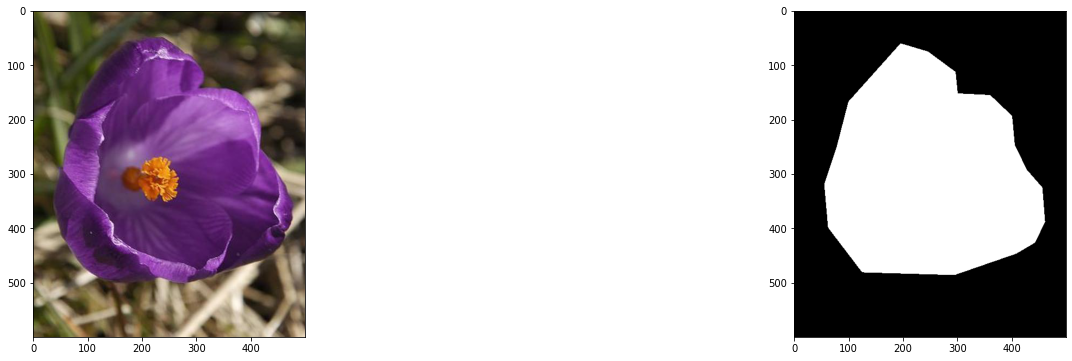

In [37]:
q = show_img_mask(ALL_IMAGES[3])

In [38]:
from torch.utils.data import Dataset


class SegmentationDataset(Dataset):
    def __init__(self, images=None, masks=None, transforms=None) -> None:
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> dict:
        image_path = self.images[idx]
        image = imread(image_path)

        result = {"image": image}

        if self.masks is not None:
            result["mask"] = imread(self.masks[idx]).mean(2) // 255

        if self.transforms is not None:
            result = self.transforms(**result)
            if result.get("mask", None) is not None:
                result["mask"] = result["mask"].unsqueeze(0)

        result["filename"] = image_path.name
        result["image size"] = image.shape[:2]

        return result

## Augmentations

To train an accurate model for a segmentation task, you need a lot of data.
Use data augmentations to simulate a bigger dataset.

In [39]:
import albumentations as albu
from albumentations.pytorch import ToTensorV2 as ToTensor
import cv2

IMAGE_SIZE = 256
train_transform = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.Resize(IMAGE_SIZE, IMAGE_SIZE),
    albu.RandomResizedCrop(IMAGE_SIZE, IMAGE_SIZE, p=0.3),
    albu.Normalize(),
    ToTensor()
])

valid_transform = albu.Compose([
    albu.Resize(IMAGE_SIZE, IMAGE_SIZE),
    albu.Normalize(),
    ToTensor()
])

In [40]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


batch_size = 8
num_workers = 2

indices = np.arange(len(ALL_IMAGES))
train_indices, valid_indices = train_test_split(indices, test_size=0.15, random_state=2, shuffle=True)

np_images = np.array(ALL_IMAGES)
np_masks = np.array(ALL_MASKS)

train_dataset = SegmentationDataset(
    images = np_images[train_indices].tolist(),
    masks = np_masks[train_indices].tolist(),
    transforms = train_transform
)

valid_dataset = SegmentationDataset(
    images = np_images[valid_indices].tolist(),
    masks = np_masks[valid_indices].tolist(),
    transforms = valid_transform
)

loaders = {
    "train": DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        drop_last=True,
    ),
    "valid": DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        drop_last=True,
    )
}

Our current baseline model is `U-Net`.
You can do anything with it: add pretrained backbone, make model wider or deeper or change a model architecture.
You can use `torchvision` module to create a backbone, but not a whole model.

In [41]:
class Unet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_1 = self.make_down_layer_(3, 64)
        self.down_2 = self.make_down_layer_(64, 128)
        self.down_3 = self.make_down_layer_(128, 256)
        self.down_4 = self.make_down_layer_(256, 512)

        self.up_1 = self.make_up_layer_(512, 256)
        self.up_2 = self.make_up_layer_(256, 128)
        self.up_3 = self.make_up_layer_(128, 64)
        self.up_4 = nn.Sequential(nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1, stride=2, output_padding=1))

    def make_down_layer_(self, in_channels, out_channels, activation=nn.LeakyReLU):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

    def make_up_layer_(self, in_channels, out_channels, activation=nn.LeakyReLU):
        return nn.ModuleList([
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(2 * out_channels),
            activation(),
            nn.ConvTranspose2d(2 * out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            activation()
        ])

    def forward(self, image):
        # print('-'*100)
        # print(f' input {image.shape}')
        d_1 = self.down_1(image)
        # print(f' d_1 {d_1.shape}')
        d_2 = self.down_2(d_1)
        # print(f' d_2 {d_2.shape}')
        d_3 = self.down_3(d_2)
        # print(f' d_3 {d_3.shape}')
        d_4 = self.down_4(d_3)
        # print(f' d_4 {d_4.shape}')

        u_1 = self.up_1[0](d_4)
        u_1 = torch.cat([d_3, u_1], axis=1)
        for m in self.up_1[1:]:
            u_1 = m(u_1)
        # print(f' u_1 {u_1.shape}')
        u_2 = self.up_2[0](u_1)
        u_2 = torch.cat([d_2, u_2], axis=1)
        for m in self.up_2[1:]:
            u_2 = m(u_2)
        # print(f' u_2 {u_2.shape}')
        u_3 = self.up_3[0](u_2)
        u_3 = torch.cat([d_1, u_3], axis=1)
        for m in self.up_3[1:]:
            u_3 = m(u_3)
        # print(f' u_3 {u_3.shape}')
        u_4 = self.up_4(u_3)
        # print(f' u_4 {u_4.shape}')
        # print('-'*100)
        return u_4

In [42]:
from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.dl.runner import SupervisedRunner
from torch.nn.functional import interpolate


class SegmentationRunner(SupervisedRunner):
    def predict_batch(self, batch):
        prediction = {"filename": batch["filename"]}
        masks = self.model(batch[self.input_key].to(self.device))
        image_size = list(zip(*batch["image size"]))
        prediction["mask"] = [
            interpolate(mask.unsqueeze(0), image_size).squeeze(0)
            for mask, image_size in zip(masks, image_size)
        ]
        return prediction

# we have multiple criterions
model = Unet()
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

logdir = Path("logs") / datetime.now().strftime("%Y%m%d-%H%M%S")
if not logdir.exists():  # hot start
    checkpoint_path = BASE_DIR.parent / 'logs' / '20211215-124831' / 'checkpoints' / 'best.pth'
    if checkpoint_path.exists():
        checkpoint = utils.load_checkpoint(filepath=checkpoint_path)
        utils.unpack_checkpoint(checkpoint, model=model)

runner = SegmentationRunner(input_key="image", input_target_key="mask", device=device)

In [67]:
callbacks = [
    dl.CriterionCallback(input_key="mask", prefix="loss_iou", criterion_key="iou"),
    dl.IouCallback(input_key="mask"),
    dl.MetricAggregationCallback(prefix="loss", mode="weighted_sum", metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},),
    dl.CriterionCallback(input_key="mask", prefix="loss_dice", criterion_key="dice"),
    dl.DiceCallback(input_key="mask"),
    dl.CriterionCallback(input_key="mask", prefix="loss_bce", criterion_key="bce"),
]

In [70]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [71]:
%tensorboard --logdir $logdir

Launching TensorBoard...

In [73]:
notebook.list()  # View open TensorBoard instances
# Control TensorBoard display. If no port is provided,
# the most recently launched TensorBoard is used
notebook.display(port=6007, height=400)

Known TensorBoard instances:
  - port 6007: logdir logs/20211216-113905 (started 0:03:05 ago; pid 8636)
  - port 6006: logdir logs/20211216-113233 (started 0:09:36 ago; pid 7860)
Selecting TensorBoard with logdir logs/20211216-113905 (started 0:03:05 ago; port 6007, pid 8636).


In [47]:
torch.cuda.empty_cache()

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    callbacks=callbacks,
    logdir=logdir,
    num_epochs=5,
    main_metric="iou", # kaggle competition metric
    minimize_metric=False,
    verbose=True,
)

1/5 * Epoch (train): 100% 43/43 [00:10<00:00,  3.97it/s, dice=0.886, iou=0.796, loss=0.467, loss_bce=0.186, loss_dice=0.114, loss_iou=0.204]
1/5 * Epoch (valid): 100% 7/7 [00:00<00:00,  8.16it/s, dice=0.881, iou=0.787, loss=0.464, loss_bce=0.164, loss_dice=0.119, loss_iou=0.213]
[2021-12-16 11:39:20,874] 
1/5 * Epoch 1 (_base): lr=0.0001 | momentum=0.9000
1/5 * Epoch 1 (train): dice=0.9351 | iou=0.8796 | loss=0.2751 | loss_bce=0.1122 | loss_dice=0.0649 | loss_iou=0.1204
1/5 * Epoch 1 (valid): dice=0.9017 | iou=0.8231 | loss=0.3925 | loss_bce=0.1466 | loss_dice=0.0983 | loss_iou=0.1769
2/5 * Epoch (train): 100% 43/43 [00:10<00:00,  3.92it/s, dice=0.940, iou=0.887, loss=0.250, loss_bce=0.098, loss_dice=0.060, loss_iou=0.113]
2/5 * Epoch (valid): 100% 7/7 [00:00<00:00,  8.42it/s, dice=0.874, iou=0.776, loss=0.485, loss_bce=0.169, loss_dice=0.126, loss_iou=0.224]
[2021-12-16 11:39:32,918] 
2/5 * Epoch 2 (_base): lr=0.0001 | momentum=0.9000
2/5 * Epoch 2 (train): dice=0.9325 | iou=0.8750 | 

## Submission

To generate submission, you'll have to write masks for images.
Usually, in `Kaggle` segmentation competitions masks are encoded in the run length format.
For more information, check `Evaluation` page in `Overview`.

In [74]:
def rle_encoding(x):
    """
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    """
    dots = np.where(x.T.flatten() == 1)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

This code below will generate a submission.
It reads images from `test` folder and gathers prediction from the trained model.
Check your submission before uploading it into `Kaggle`.

In [75]:
from PIL import Image
import pandas as pd

submission = {"ImageId": [], "EncodedPixels": []}
threshold = 0.5

test_image_path = BASE_DIR / 'test'
TEST_IMAGES = sorted(test_image_path.glob("*.png"))
test_dataset = SegmentationDataset(images=TEST_IMAGES, transforms=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers,)

for prediction in runner.predict_loader(loader=test_loader):
    submission["ImageId"].extend(s[:-4] for s in prediction["filename"])
    submission["EncodedPixels"].extend(rle_encoding(torch.sigmoid(mask).cpu().numpy().mean(0) > threshold) for mask in prediction["mask"])

In [76]:
def show_predict2(img_name, model=Unet, device=device, treshold=None, original=True):
    with torch.no_grad():
        net = model().to(device)
        img = cv2.imread(str(img_name))
        h,w,c = img.shape

        transformed_img = valid_transform(image=img)['image'].unsqueeze(0)
        mask = net(transformed_img.to(device))

    # mask = mask.squeeze().cpu().detach().numpy()

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    if original:
        resizer = albu.Resize(height=h, width=w, p=1)
        res_mask = resizer(image=mask.astype('float32'))['image']
        if treshold is not None:
            res_mask = (res_mask > treshold).int()
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), label='image')
        ax[1].imshow(res_mask, cmap='gray', label='mask')
        return res_mask
    else:
        if treshold is not None:
            mask = (mask > treshold).int()
        ax[0].imshow(img, label='image')
        ax[1].imshow(mask, cmap='gray', label='mask')
        return mask

In [77]:
def show_predict(img_name, model=Unet, device=device, treshold=None, original=True):
    with torch.no_grad():
        net = model().to(device)
        img = cv2.imread(str(img_name))
        h,w,c = img.shape

        transformed_img = valid_transform(image=img)['image'].unsqueeze(0)
        mask = net(transformed_img.to(device))

    mask = mask.squeeze().cpu().detach().numpy()

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    if original:
        resizer = albu.Resize(height=h, width=w, p=1)
        res_mask = resizer(image=mask)['image']
        if treshold is not None:
            res_mask = (res_mask > treshold).astype(int)
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), label='image')
        ax[1].imshow(res_mask, cmap='gray', label='mask')
        return res_mask
    else:
        if treshold is not None:
            mask = (mask > treshold).astype(int)
        ax[0].imshow(img, label='image')
        ax[1].imshow(mask, cmap='gray', label='mask')
        return mask

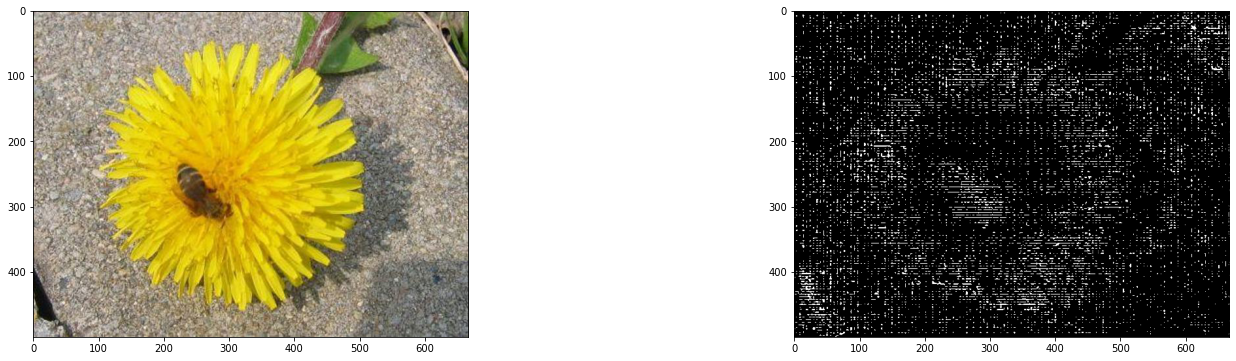

In [110]:
q = show_predict(TEST_IMAGES[2], treshold=0.5)

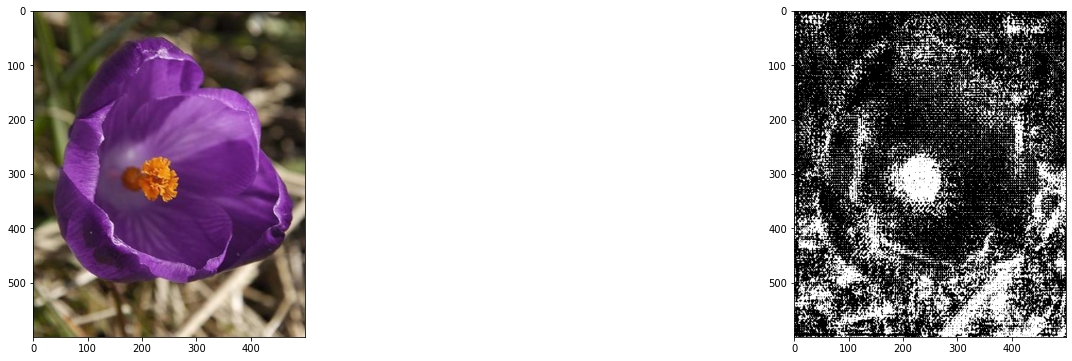

In [79]:
pred = show_predict(ALL_IMAGES[3], treshold=0.5)

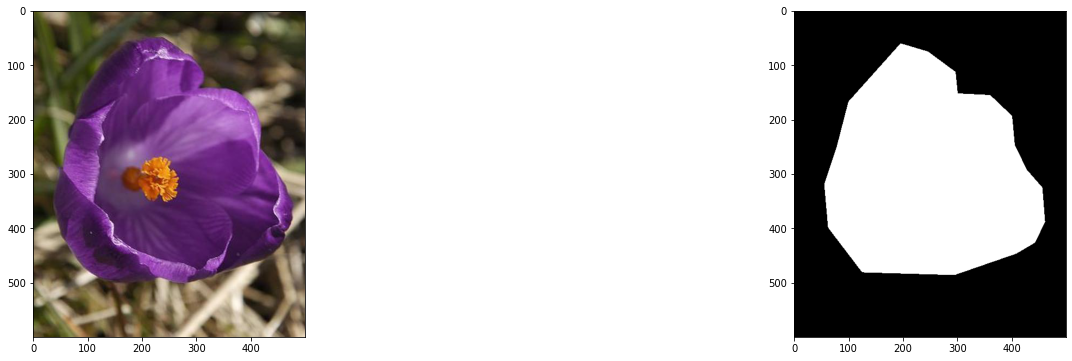

In [80]:
gt = show_img_mask(ALL_IMAGES[3])

In [106]:
gt_t = torch.Tensor(gt).unsqueeze(0)
pred_t = torch.Tensor(pred).unsqueeze(0)

iou = IoULoss(threshold=0.5, activation='Sigmoid')
iou(outputs=pred_t, targets=gt_t)

tensor(0.7248)

In [83]:
pd.DataFrame(submission).to_csv("submission.csv", index=False)

In [84]:
pd.DataFrame(submission)

,ImageId,EncodedPixels
0,image_ecf9e914,104761 4 105261 4 105742 27 106242 27 106742 2...
1,image_ecf9eab8,126812 6 127312 6 127812 6 128310 8 128810 8 1...
2,image_ecf9eba8,66742 8 66787 2 66818 8 67242 8 67287 2 67318 ...
3,image_ecf9ee3c,91234 6 91734 6 92144 16 92230 16 92644 16 927...
4,image_ecf9eee6,77794 8 78294 8 78794 8 79294 10 79794 10 8029...
...,...,...
432,image_ecfbd5b2,34948 6 35652 6 36354 11 37058 11 37759 14 384...
433,image_ecfbd62a,47126 18 47626 18 48126 18 48621 29 49121 29 4...
434,image_ecfbd724,39108 3 39838 3 40562 9 41292 9 41706 17 42022...
435,image_ecfbd81e,39947 2 40662 2 41377 8 41421 6 41432 3 42092 ...
